# Data Undetstanding

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [131]:
df=pd.read_csv('/Users/xiaoming/Library/CloudStorage/OneDrive-AsiaPacificUniversity/Degree Y3S2/FYP/retail_store_inventory.csv')

In [132]:
print("ROW, COLUMNS: \n", df.shape)
print("\nATTRIBUTES DATA TYPES: \n", df.dtypes)


ROW, COLUMNS: 
 (73100, 15)

ATTRIBUTES DATA TYPES: 
 Date                   object
Store ID               object
Product ID             object
Category               object
Region                 object
Inventory Level         int64
Units Sold              int64
Units Ordered           int64
Demand Forecast       float64
Price                 float64
Discount                int64
Weather Condition      object
Holiday/Promotion       int64
Competitor Pricing    float64
Seasonality            object
dtype: object


In [133]:
print("\nMISSING DATA: \n",df.isnull().sum())
print("\nDUPLICATES DATA: ",df.duplicated().sum())



MISSING DATA: 
 Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

DUPLICATES DATA:  0


In [134]:
print("UNIQUE VALUE:")
for col in ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']:
    print(f"{col}: {df[col].nunique()} unique values")

UNIQUE VALUE:
Store ID: 5 unique values
Product ID: 20 unique values
Category: 5 unique values
Region: 4 unique values
Weather Condition: 4 unique values
Seasonality: 4 unique values


In [135]:
num_cols = ['Inventory Level', 'Units Sold', 'Units Ordered',
            'Demand Forecast', 'Price', 'Discount', 'Competitor Pricing',]
print("\nNumerical Columns Stats:")
print(df[num_cols].describe())


Numerical Columns Stats:
       Inventory Level    Units Sold  Units Ordered  Demand Forecast  \
count     73100.000000  73100.000000   73100.000000     73100.000000   
mean        274.469877    136.464870     110.004473       141.494720   
std         129.949514    108.919406      52.277448       109.254076   
min          50.000000      0.000000      20.000000        -9.990000   
25%         162.000000     49.000000      65.000000        53.670000   
50%         273.000000    107.000000     110.000000       113.015000   
75%         387.000000    203.000000     155.000000       208.052500   
max         500.000000    499.000000     200.000000       518.550000   

              Price      Discount  Competitor Pricing  
count  73100.000000  73100.000000        73100.000000  
mean      55.135108     10.009508           55.146077  
std       26.021945      7.083746           26.191408  
min       10.000000      0.000000            5.030000  
25%       32.650000      5.000000           3

In [136]:
df['Date'] = pd.to_datetime(df['Date'])

# Step 3: Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Step 4: Extract the 'Units Sold' column and reshape it for scaling
Units_Sold = df['Units Sold'].astype(float).values.reshape(-1, 1)

# Step 5: Apply MinMaxScaler to scale 'Units Sold' between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(Units_Sold)

# Display the scaled data (first few values) and a portion of the DataFrame
df['Scaled Units Sold'] = scaled_data  # Adding the scaled data to the dataframe for reference
print(df.head())

           Store ID Product ID     Category Region  Inventory Level  \
Date                                                                  
2022-01-01     S001      P0001    Groceries  North              231   
2022-01-01     S001      P0002         Toys  South              204   
2022-01-01     S001      P0003         Toys   West              102   
2022-01-01     S001      P0004         Toys  North              469   
2022-01-01     S001      P0005  Electronics   East              166   

            Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
Date                                                                      
2022-01-01         127             55           135.47  33.50        20   
2022-01-01         150             66           144.04  63.01        20   
2022-01-01          65             51            74.02  27.99        10   
2022-01-01          61            164            62.18  32.72        10   
2022-01-01          14            135             9.

In [137]:
import numpy as np
from sklearn.model_selection import train_test_split

# Set the window size for time series (12 days for prediction)
window_size = 12

# Initialize empty lists to store the features and targets
X = []
y = []

# Select relevant features from your dataset (you can choose whichever columns you'd like)
# For example, we can use all the columns except 'Date' and 'Units Sold' as features
features = ['Inventory Level', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Competitor Pricing', 'Weather Condition', 'Holiday/Promotion', 'Seasonality']

# Use the scaled 'Units Sold' data to create X (features) and y (targets)
target_dates = df.index[window_size:]

# Creating features (X) and targets (y)
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, :])  # Last 12 days for each sample, including all features
    y.append(scaled_data[i, 0])  # The next day's 'Units Sold' value as target

# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets (80% train, 20% test) while preserving the time series order
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, target_dates, test_size=0.2, shuffle=False
)

# Reshape the data for LSTM input: [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))  # Adjusted for multiple features
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # Adjusted for multiple features

# Display the shape of the reshaped data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (58470, 12, 1)
X_test shape: (14618, 12, 1)
y_train shape: (58470,)
y_test shape: (14618,)


In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Step 1: Define the model architecture
model = Sequential()

# First LSTM layer with 128 units and return sequences for the next LSTM layer
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Add dropout layer to prevent overfitting

# Second LSTM layer with 128 units
model.add(LSTM(units=128))
model.add(Dropout(0.2))  # Add another dropout layer

# Output layer with 1 unit to predict the sales for the next day
model.add(Dense(1))

# Step 2: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 3: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Step 4: Evaluate the model's performance
# After training, we can evaluate it on the test data or make predictions
print("Model trained successfully!")

Epoch 1/20


/Users/xiaoming/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


439/914 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0500

KeyboardInterrupt: 

In [ ]:
# Step 1: Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Step 2: Make predictions on the test set
predictions = model.predict(X_test)

# Step 3: Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions).flatten()  # Flatten to make it 1D array
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()  # Flatten the actual values as well

# Step 4: Calculate RMSE
rmse = np.sqrt(np.mean((y_test_original - predictions) ** 2))
print(f'RMSE: {rmse:.2f}')

Epoch 1/100
  87/1645 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0468

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Plot actual vs predicted production
plt.figure(figsize=(12, 6))

# Plot the actual production
plt.plot(dates_test, y_test_original, label='Actual Units Sold', color='blue')

# Plot the predicted production
plt.plot(dates_test, predictions, label='Predicted Units Sold', color='red')

# Add title and labels
plt.title('Actual vs Predicted Units Sold')
plt.xlabel('Date')
plt.ylabel('Units Sold')

# Add a legend
plt.legend()

# Show the plot
plt.show()

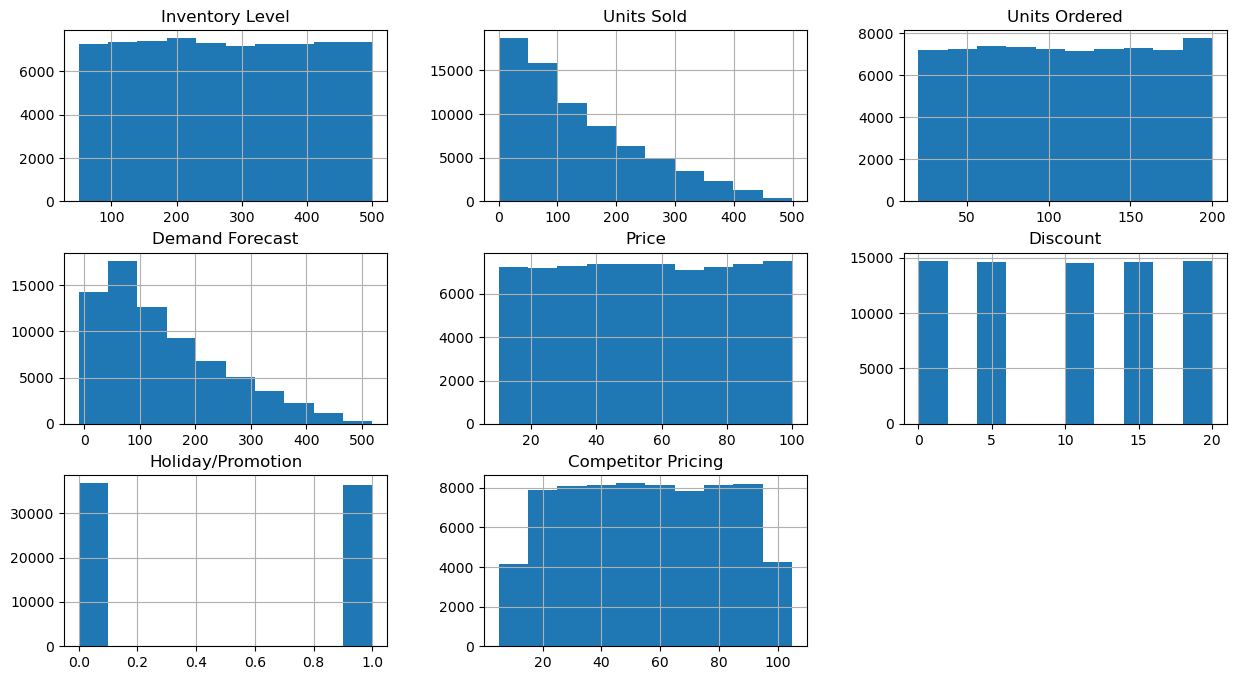

In [ ]:
df.hist(figsize=(15,8))
plt.show()

In [ ]:
df = df.drop('Demand Forecast', axis = 1)

KeyError: "['Demand Forecast'] not found in axis"